## H2: Particle filter for a linear Gaussian state-space model

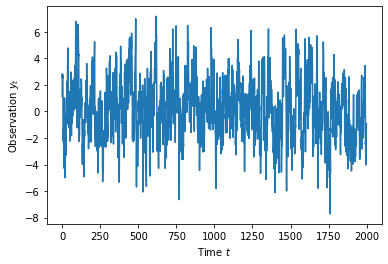

In [6]:
import os
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def generate_data(T):
    y = np.zeros(T)
    x = np.zeros(T+1)
    x[0] = np.random.normal(loc=0.0, scale=np.sqrt(2.0) )
    for t in range(T):
        x[t+1] = np.random.normal(loc=0.8*x[t], scale=np.sqrt(0.5))
        y[t] = np.random.normal(loc=2*x[t+1], scale=np.sqrt(0.1))
    return y, x

np.random.seed(42)
y, x = generate_data(T=2000)
plt.plot(y)
plt.xlabel("Time $t$"); plt.ylabel("Observation $y_t$");
plt.show()

In [ ]:
# Implement the Kalman filter!